# CNN
Training auf Hybrid_b17_test 80%  
Validierung auf Hybrid_b17_test 10%   
Test auf Hybrid_b17_test 10%  
Test auf Hybrid_b17_train mit reduzierten Benign Daten folgt in cnn_test

In [ ]:
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import joblib
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# Maximale Zeilen und Spalten anzeigen
pd.set_option('display.max_rows', None)  # Zeilen
pd.set_option('display.max_columns', None)  # Spalten

# Logging Parameter
logging.basicConfig(
    #filename='',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [ ]:
!nvidia-smi

### Laden des Hybrid-Trainingsdatensatzes

In [4]:
# Hybrid-Trainingsdatensatz laden
hybrid_b17_train = pd.read_parquet('../01_Datensaetze/improved_hybrid_b17/hybrid_b17_train.parquet')
logging.info("Class distribution\n{}".format(hybrid_b17_train.Label.value_counts()))

2024-11-01 12:17:08 - INFO - Class distribution
Label
DoS Hulk                        1803160
BENIGN                          1424304
DDoS-LOIC-HTTP                   289328
Botnet Ares                      142921
SSH-BruteForce                    94197
Infiltration - NMAP Portscan      89374
DoS GoldenEye                     22560
DoS Slowloris                      8490
Web Attack - Brute Force            131
Web Attack - XSS                    113
Web Attack - SQL                     39
Name: count, dtype: int64


In [5]:
logging.info(hybrid_b17_train.shape)
logging.info(hybrid_b17_train.columns)

2024-11-01 12:17:08 - INFO - (3874617, 84)
2024-11-01 12:17:08 - INFO - Index(['Dst Port', 'Protocol', 'Flow Duration', 'Total Fwd Packet',
       'Total Bwd packets', 'Total Length of Fwd Packet',
       'Total Length of Bwd Packet', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd RST Flags', 'Bwd RST Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max',
       'Pac

### Trennen von Features und Labels

In [6]:
X = hybrid_b17_train.iloc[:, :-1]  # Alle Spalten außer der letzten
print("Form von X:", X.shape)
y = hybrid_b17_train.iloc[:, -1]   # Die letzte Spalte 'Label' ist die Zielvariable
print("Form von y:", y.shape)


Form von X: (3874617, 83)
Form von y: (3874617,)


### Label Encoding für y

In [9]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [10]:
print("Einzigartige Labels:", label_encoder.classes_)
print("Kodierte Labels:", np.unique(y_encoded))

Einzigartige Labels: ['BENIGN' 'Botnet Ares' 'DDoS-LOIC-HTTP' 'DoS GoldenEye' 'DoS Hulk'
 'DoS Slowloris' 'Infiltration - NMAP Portscan' 'SSH-BruteForce'
 'Web Attack - Brute Force' 'Web Attack - SQL' 'Web Attack - XSS']
Kodierte Labels: [ 0  1  2  3  4  5  6  7  8  9 10]


### Skallierung von X

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Form von X:", X.shape)
print("Form von X_scaled:", X_scaled.shape)

Form von X: (3874617, 83)
Form von X_scaled: (3874617, 83)


### Umformen der Daten für das CNN

In [12]:
# Anzahl der Features
num_features = X_scaled.shape[1]  # Sollte 83 sein

# Umformen zu (Anzahl_Beispiele, num_features, 1)
X_reshaped = X_scaled.reshape(-1, num_features, 1)
print("Form von X_reshaped:", X_reshaped.shape)  # Erwartet: (1923167, 83, 1)

Form von X_reshaped: (3874617, 83, 1)


### Aufteilen der Daten in Trainings-, Validierungs- und Testdatensätze

In [13]:
# Aufteilen in Trainings- und temporären Datensatz
X_train, X_temp, y_train, y_temp = train_test_split(
    X_reshaped, y_encoded, test_size=0.20, random_state=42, stratify=y_encoded)

# Aufteilen des temporären Datensatzes in Validierung und Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Form von X_train:", X_train.shape)
print("Form von X_val:", X_val.shape)
print("Form von X_test:", X_test.shape)

Form von X_train: (3099693, 83, 1)
Form von X_val: (387462, 83, 1)
Form von X_test: (387462, 83, 1)


### Überprüfen der Klassenverteilung

In [14]:
def print_class_distribution(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    print(f"Klassenverteilung in {dataset_name}:")
    for cls, count in zip(unique, counts):
        print(f"  Klasse {cls}: {count} Beispiele ({(count/total)*100:.2f}%)")
    print()

print_class_distribution(y_train, "Trainingsdatensatz")
print_class_distribution(y_val, "Validierungsdatensatz")
print_class_distribution(y_test, "Testdatensatz")

Klassenverteilung in Trainingsdatensatz:
  Klasse 0: 1139443 Beispiele (36.76%)
  Klasse 1: 114337 Beispiele (3.69%)
  Klasse 2: 231462 Beispiele (7.47%)
  Klasse 3: 18048 Beispiele (0.58%)
  Klasse 4: 1442528 Beispiele (46.54%)
  Klasse 5: 6792 Beispiele (0.22%)
  Klasse 6: 71499 Beispiele (2.31%)
  Klasse 7: 75358 Beispiele (2.43%)
  Klasse 8: 105 Beispiele (0.00%)
  Klasse 9: 31 Beispiele (0.00%)
  Klasse 10: 90 Beispiele (0.00%)

Klassenverteilung in Validierungsdatensatz:
  Klasse 0: 142430 Beispiele (36.76%)
  Klasse 1: 14292 Beispiele (3.69%)
  Klasse 2: 28933 Beispiele (7.47%)
  Klasse 3: 2256 Beispiele (0.58%)
  Klasse 4: 180316 Beispiele (46.54%)
  Klasse 5: 849 Beispiele (0.22%)
  Klasse 6: 8938 Beispiele (2.31%)
  Klasse 7: 9419 Beispiele (2.43%)
  Klasse 8: 13 Beispiele (0.00%)
  Klasse 9: 4 Beispiele (0.00%)
  Klasse 10: 12 Beispiele (0.00%)

Klassenverteilung in Testdatensatz:
  Klasse 0: 142431 Beispiele (36.76%)
  Klasse 1: 14292 Beispiele (3.69%)
  Klasse 2: 28933 Bei

 ### Modell erstellen und trainieren

In [15]:
def create_cnn_model(num_features, num_classes):
    inputs = keras.layers.Input(shape=(num_features, 1))
    x = keras.layers.Conv1D(120, kernel_size=2, activation='relu', padding="same")(inputs)
    x = keras.layers.Conv1D(60, kernel_size=3, activation='relu', padding="same")(x)
    x = keras.layers.Conv1D(30, kernel_size=4, activation='relu', padding="same")(x)
    x = keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    cnn_model = keras.Model(inputs=inputs, outputs=outputs, name='cnn')

    # Kompilieren des Modells
    cnn_model.compile(loss='sparse_categorical_crossentropy',
                      metrics=['sparse_categorical_accuracy'],
                      optimizer='adam')

    return cnn_model

# Anzahl der Klassen (Labels)
num_classes = len(label_encoder.classes_)

# Modell erstellen
cnn_model = create_cnn_model(num_features, num_classes)
cnn_model.summary()


I0000 00:00:1730459835.548478  878401 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730459835.565967  878401 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730459835.566005  878401 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730459835.567869  878401 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730459835.567897  878401 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 83, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 83, 120)        │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 83, 60)         │        21,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 83, 30)         │         7,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2490)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 11)             │        27,401 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,651 (221.29 KB)

 Trainable params: 56,651 (221.29 KB)

 Non-trainable params: 0 (0.00 B)

### Trainieren des Modells

In [16]:
cnn_model.fit(
    X_train, y_train,
    epochs=2,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/2


I0000 00:00:1730459871.899268  878598 service.cc:146] XLA service 0x7f0f90004500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730459871.899296  878598 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-11-01 12:17:51.911958: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-01 12:17:51.977124: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  131/96866 ━━━━━━━━━━━━━━━━━━━━ 1:52 1ms/step - loss: 0.8267 - sparse_categorical_accuracy: 0.8150 

I0000 00:00:1730459873.192458  878598 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


96866/96866 ━━━━━━━━━━━━━━━━━━━━ 129s 1ms/step - loss: 0.0104 - sparse_categorical_accuracy: 0.9979 - val_loss: 0.0036 - val_sparse_categorical_accuracy: 0.9998
Epoch 2/2
96866/96866 ━━━━━━━━━━━━━━━━━━━━ 125s 1ms/step - loss: 0.0012 - sparse_categorical_accuracy: 0.9998 - val_loss: 5.9538e-04 - val_sparse_categorical_accuracy: 0.9999


### Evaluierung des Modells auf dem Testdatensatz

In [17]:
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Testverlust: {test_loss:.4f}")
print(f"Testgenauigkeit: {test_accuracy:.4f}")

12109/12109 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 3.7929e-04 - sparse_categorical_accuracy: 0.9999
Testverlust: 0.0006
Testgenauigkeit: 0.9999


### Klassifikationsbericht und eine Konfusionsmatrix

In [18]:
# Vorhersagen auf dem Testdatensatz
y_pred_prob = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# Klassifikationsbericht
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_classes)
print("Konfusionsmatrix:")
print(cm)

12109/12109 ━━━━━━━━━━━━━━━━━━━━ 8s 638us/step
                              precision    recall  f1-score   support

                      BENIGN       1.00      1.00      1.00    142431
                 Botnet Ares       1.00      1.00      1.00     14292
              DDoS-LOIC-HTTP       1.00      1.00      1.00     28933
               DoS GoldenEye       1.00      1.00      1.00      2256
                    DoS Hulk       1.00      1.00      1.00    180316
               DoS Slowloris       1.00      1.00      1.00       849
Infiltration - NMAP Portscan       1.00      1.00      1.00      8937
              SSH-BruteForce       1.00      1.00      1.00      9420
    Web Attack - Brute Force       1.00      1.00      1.00        13
            Web Attack - SQL       1.00      0.75      0.86         4
            Web Attack - XSS       1.00      1.00      1.00        11

                    accuracy                           1.00    387462
                   macro avg       1.00  

Visualisierung der Konfusionsmatrix

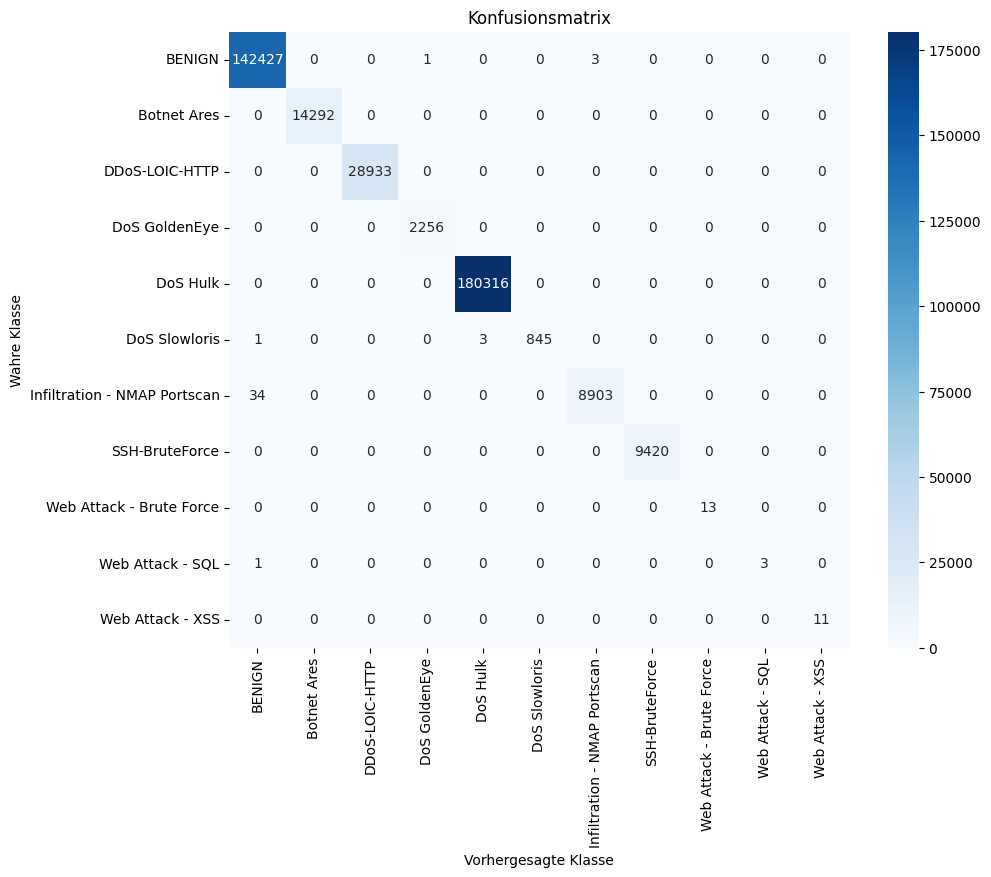

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wahre Klasse')
plt.title('Konfusionsmatrix')
plt.show()


### Speichern des Modells und der Vorverarbeitungsschritte

In [ ]:
cnn_model.save('hybrid_cnn_model.h5')
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')

2024-11-01 12:25:22 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


['scaler.pkl']